In [2]:
from dotenv import load_dotenv
load_dotenv()

import getpass
import os

if not os.environ.get("AZURE_OPENAI_API_KEY"):
    os.environ["AZURE_OPENAI_API_KEY"] = getpass.getpass("Enter API key for Azure: ")

from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings

model = AzureChatOpenAI(
    azure_endpoint="https://menoua.openai.azure.com/openai/deployments/gpt-4.1/chat/completions?api-version=2025-01-01-preview",
    azure_deployment="gpt-41",
    api_version="2025-01-01-preview",
    temperature=0,
    use_responses_api=False,
)

embeddings = AzureOpenAIEmbeddings(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    chunk_size=64,
    # max_retries=10,
    # retry_min_seconds=10,
    # retry_max_seconds=60,
)

In [3]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

In [3]:
docs[0][0].page_content.strip()[:1000]

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      Reward Hacking in Reinforcement Learning\n    \nDate: November 28, 2024  |  Estimated Reading Time: 37 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nBackground\n\nReward Function in RL\n\nSpurious Correlation\n\n\nLet’s Define Reward Hacking\n\nList of Examples\n\nReward hacking examples in RL tasks\n\nReward hacking examples in LLM tasks\n\nReward hacking examples in real life\n\n\nWhy does Reward Hacking Exist?\n\n\nHacking RL Environment\n\nHacking RLHF of LLMs\n\nHacking the Training Process\n\nHacking the Evaluator\n\nIn-Context Reward Hacking\n\n\nGeneralization of Hacking Skills\n\nPeek into Mitigations\n\nRL Algorithm Improvement\n\nDetecting Reward Hacking\n\nData Analysis of RLHF\

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [5]:
doc_splits[0].page_content.strip()

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ"

In [8]:
from langchain_core.vectorstores import InMemoryVectorStore

vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=embeddings
)

retriever = vectorstore.as_retriever()


In [7]:
from langchain.tools import tool

@tool
def retrieve_blog_posts(query: str) -> str:
    """Search and return information about Lilian Weng blog posts."""
    docs = retriever.invoke(query)
    return "\n\n".join([doc.page_content for doc in docs])

retriever_tool = retrieve_blog_posts

In [9]:
from langchain.tools import tool

@tool
def retrieve_blog_posts(query: str) -> str:
    """Search and return information about Lilian Weng blog posts."""
    docs = retriever.invoke(query)
    return "\n\n".join([doc.page_content for doc in docs])

retriever_tool = retrieve_blog_posts

In [10]:
retriever_tool.invoke({"query": "types of reward hacking"})

'Detecting Reward Hacking#\n\nIn-Context Reward Hacking#\n\n(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)\nAt a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.\n\nWhy does Reward Hacking Exist?#'

In [11]:
from langgraph.graph import MessagesState

def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        model
        .bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}

In [12]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! How can I help you today?


In [15]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "What does Lilian Weng say about types of reward hacking?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_iO2BuKd9O8QiCDfARBMdlALo)
 Call ID: call_iO2BuKd9O8QiCDfARBMdlALo
  Args:
    query: types of reward hacking


In [16]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


grader_model = model


def grade_documents(
        state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

In [21]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

In [22]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

'rewrite_question'

In [24]:
from langchain.messages import HumanMessage

REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [HumanMessage(content=response.content)]}

In [25]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1].content)

Certainly! Here’s an improved version of the question:

**"How does Lilian Weng categorize and explain different types of reward hacking in her work?"**


In [26]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [27]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

Lilian Weng says that reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering. These categories describe different ways in which an agent might exploit flaws in the reward system. Environment or goal misspecification involves unintended behaviors due to poorly specified objectives, while reward tampering involves directly manipulating the reward signal.


In [28]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

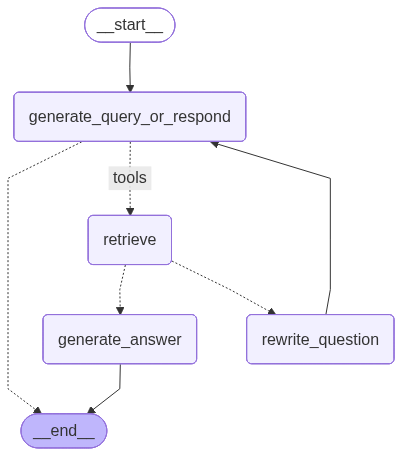

In [29]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
for chunk in graph.stream(
        {
            "messages": [
                {
                    "role": "user",
                    "content": "What does Lilian Weng say about types of reward hacking?",
                }
            ]
        }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_gOHb3Z2qAHv4bnJIpAQGoCuf)
 Call ID: call_gOHb3Z2qAHv4bnJIpAQGoCuf
  Args:
    query: types of reward hacking



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_blog_posts

Detecting Reward Hacking#

In-Context Reward Hacking#

(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)
At a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.

Why does Reward Hacking Exist?#



Update from node generate_answer
================================== Ai Message ==================================

Lilian Weng categorizes reward hacking into two types: environment or goal misspecificat